# A Naive Bayes Classifier

In [196]:
import numpy as np
np.seterr(divide='ignore') # happy with log(0) = -inf
from math import log, pi

class NBC:
    def __init__(self, feature_types):
        self.feature_types = feature_types
    
    def fit(self, X, y):
        if hasattr(self, "logpi"):
            raise Exception("Already fitted")
        if X.shape[1] != len(self.feature_types):
            raise Exception("Wrong number of features")
                    
        self.classes = np.unique(y)
        self.class_map = {v: k[0] for k, v in np.ndenumerate(self.classes)}
                    
        self.logpi = np.log([np.count_nonzero(y == c) for c in self.classes]) - log(y.shape[0])
        
        means = []
        stddevs = []
        for class_ in self.classes:
            X_ = X[np.where(y == class_)]
            means.append(np.mean(X_, axis = 0))
            stddevs.append(np.std(X_, axis = 0))
        self.means = np.array(means).T
        self.stddevs = np.array(stddevs).T
        
    def predict(self, X):
        if X.shape[1] != len(self.feature_types):
            raise Exception("Wrong number of features")        
        
        X = np.repeat(np.expand_dims(X, axis=2), self.classes.size, axis=2)
        # X.shape == (data, features, classes)
        
        for class_ in range(self.classes.size):
            bernoulli_features = np.where(self.feature_types == 'b')[0]
            if bernoulli_features.shape[0] > 0:
                # Set X[data, feature, class] = log(P(X[data, feature, class) | mean[feature, class]))
                # for Bernoulli features using the pmf
                mean = self.means[bernoulli_features, class_]
                X[:, bernoulli_features, class_] = X[:, bernoulli_features, class_]*np.log(mean) + (1-X[:, bernoulli_features, class_]) * np.log(1-mean)
            gaussian_features = np.where(self.feature_types == 'r')[0]
            if gaussian_features.shape[0] > 0:
                mean = self.means[gaussian_features, class_]
                stddev = self.stddevs[gaussian_features, class_]
                # Set X[data, feature, class] = log(P(X[data, feature, class) | mean[feature, class], stddev[feature, class]))
                # for Normal features using the pdf
                X[:, gaussian_features, class_] = -1/2*np.log(2*pi*stddev) - (X[:, gaussian_features, class_]-mean)**2/2/stddev 
        
        X = np.sum(X, axis = 1) + self.logpi
        # X[data, class] = log(P(data | class))

        y = np.argmax(X, axis=1)
        # y[data] == argmax_c P(data | class)
                
        return self.classes[y]

# LR Regularisation
In `LogisticRegression` the parameter $C$ is multiplied with everything but the regularization term of the optimization function, so setting $C = \lambda^{-1}$ gives the same minimum as multiplying $\lambda$ with the regularization term.

In [223]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

def trainAndReportError(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    return np.mean(classifier.predict(X_train) == y_train)

def compare(X, y, features):
    index_series = range(10, 101, 10)
    nbc_series = np.zeros(len(index_series))
    lr_series = np.zeros(len(index_series))
    
    runs = 1000
    for run in range(runs):
        N, D = X.shape
        Ntrain = int(0.8 * N)
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]
        nbc_errors = [trainAndReportError(NBC(features), Xtrain[:Ntrain*i/100], ytrain[:Ntrain*i/100], Xtest, ytest) 
                      for i in index_series]
        lr_errors = [trainAndReportError(LogisticRegression(C = 10), Xtrain[:Ntrain*i/100], ytrain[:Ntrain*i/100], Xtest, ytest) 
                     for i in index_series]
        nbc_series += np.array(nbc_errors)
        lr_series += np.array(lr_errors)
        
    nbc_series /= runs
    lr_series /= runs

    plt.plot(index_series, nbc_series, 'b')
    plt.plot(index_series, lr_series, 'r')
    plt.show()

# Iris Dataset
We're plotting testing error for NBC (blue) and LR (red) against the percentage of the training set that the classifiers were trained on.

/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in divide
/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in subtract


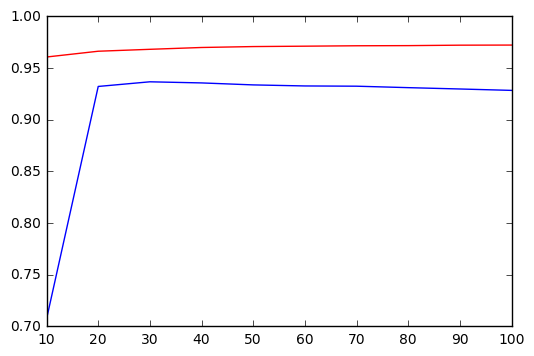

In [224]:
from sklearn.datasets import load_iris
iris = load_iris()
compare(iris['data'], iris['target'], np.repeat('r', 4))

# Congress Dataset
We're plotting testing error for NBC (blue) and LR (red) against the percentage of the training set that the classifiers were trained on.

/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in multiply


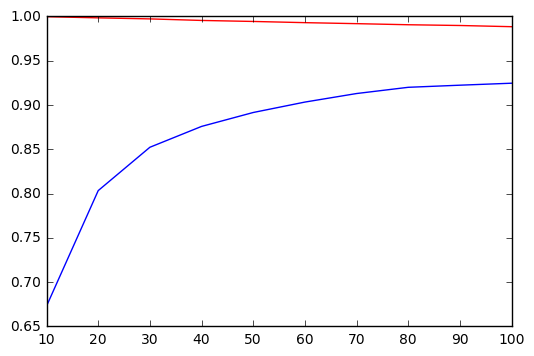

In [225]:
X, y = cp.load(open('data/voting.cPickle', 'rb'))
compare(X, y, np.repeat('b', X.shape[1]))